In [39]:
import scripts as S
import os
import pandas as pd
import importlib

In [41]:
class BackTest:
    def __init__(self,loc):
        self.loc = loc
        self.allStockList = os.listdir(self.loc)
        self.stockVal = 'close'
        self.scriptPath = "scripts"
        self.savePath = "results"
        
    def parseAction(self,a):
        a = a.lower()
        if a in ['buy','sell']:
            return a
        return ''
    
    def getTradeSummary(self,df,trades):
        totalBuy = 0
        totalSell = 0
        totalInvestment = 0
        totalNetWorth = 0
        NumberOfTrades = 0
        stocksInHand = 0 # shorting is not allowed
        
        assert len(df) == len(trades),"len of trade should be equal to stock result"
        L = len(df)
        
        for i in range(L):
            trade = trades[i]
            stock = df.iloc[i]
            
            action = self.parseAction(trade['actions'])
            qty  = int(0 if trade['quantity'] == '' else trade['quantity'])
            
            if action == 'buy':
                totalBuy += qty
                totalInvestment += qty*stock[self.stockVal]
                stocksInHand += qty
                
            if action == 'sell':
                
                totalSell += qty  
                totalNetWorth += qty*stock[self.stockVal]
                assert stocksInHand >= qty,"trying to sell more than you have"
                stocksInHand -= qty
                
            if action in ['buy','sell']:
                NumberOfTrades += 1
        
        ans = {}
        ans["totalInvestment"] = totalInvestment
        ans["totalNetWorth"] = totalNetWorth
        ans["NumberOfTrades"] = NumberOfTrades
        ans["totalBuy"] = totalBuy
        ans["totalSell"] = totalSell
        ans["currentStocksInHandValue"] = 0
#         print(df.iloc[-1][self.stockVal],stocksInHand,"stocks in hand")
        if stocksInHand > 0:
            ans["currentStocksInHandValue"] = df.iloc[-1][self.stockVal]*stocksInHand
        try:
            ans["profitPercent"] = (ans["totalNetWorth"]+ans["currentStocksInHandValue"]
                              -ans["totalInvestment"])/ans["totalInvestment"]
        except:
            ans["profitPercent"] = 0
        return ans
        
    def getScriptsName(self):
        names = [i[:-3] for i in os.listdir(self.scriptPath) if i[-3:] == '.py' and i != '__init__.py']
        return names
    
    def backtest(self,scriptName,stocksList=[]):
        """scriptFunciton import and pass it 
        stocksList if empty will pick all the stocks else only the provided ones"""
        stocksList = self.allStockList if len(stocksList) == 0 else stocksList
        scriptName = self.getScriptsName() if len(scriptName) == 0 else scriptName

        for sc_name in scriptName:
            # select Scripts
            module = importlib.import_module('scripts.'+sc_name)
            scriptFunction = module.run
            li = []
            for i in stocksList:
                df = pd.read_csv(os.path.join(loc,i))
                trades = scriptFunction(df)
                res = self.getTradeSummary(df,trades)
                res["name"] = i.split('.')[0]
                print(i,end = ' ')
                li.append(res)

            df = pd.DataFrame(li)
            df.to_csv(os.path.join(self.savePath,sc_name+".csv"),index=False)
            print(sc_name)

stocksList = []#['ONGC.csv','RELIANCE.csv','INFY.csv']
scriptNames = []
loc = "../data/stockData/daily/"
scriptPath = "scripts"
bt = BackTest(loc)
# bt.backtest(scriptNames,stocksList)

In [56]:
df = pd.read_csv(loc+"ONGC.csv")

In [59]:
df["avgShort"] = df["close"].rolling(window=5).mean()
df["avgLong"] = df["close"].rolling(window=10).mean()

<AxesSubplot:xlabel='timestamp'>

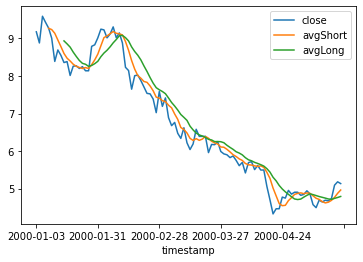

In [60]:
df.iloc[0:100].plot(x='timestamp',y=['close','avgShort','avgLong'])

In [50]:
df.head(10)

,timestamp,open,high,low,close,volume,avg5
0,2000-01-03,8.813110,9.217224,8.813110,9.176382,86400,NaN
1,2000-01-04,8.662642,9.015167,8.641147,8.879746,161100,NaN
2,2000-01-05,8.641150,9.591247,8.619654,9.591247,243000,NaN
3,2000-01-06,10.059845,10.098537,9.354795,9.427880,320400,NaN
4,2000-01-07,9.586947,9.586947,9.157039,9.275264,102600,9.270104
5,2000-01-10,8.813111,9.371992,8.813111,9.006570,360000,9.236141
6,2000-01-11,9.028066,9.028066,8.340213,8.387503,262800,9.137693
7,2000-01-12,8.810964,9.019469,8.598159,8.692739,150300,8.957991
8,2000-01-13,8.684139,8.724979,8.512175,8.548717,405000,8.782158
9,2000-01-14,8.344513,8.469186,8.301522,8.357410,293400,8.598588


In [36]:
df.sort_values('profitPercent',ascending=False,inplace=True)
df.dropna()

,totalInvestment,totalNetWorth,NumberOfTrades,totalBuy,totalSell,currentStocksInHandValue,profitPercent,name
89,2.178958e+05,3.176020e+06,33,1076,674,83696.398773,13.959978,MAZDOCK
210,5.239400e+05,5.753194e+05,38,1239,1102,114196.348328,0.316021,HAPPSTMNDS
584,3.986614e+05,2.169041e+05,34,1172,674,279203.712158,0.244434,ANGELBRKG
605,4.638480e+05,3.649901e+05,80,2184,1842,198137.691650,0.214035,PRINCEPIPE
498,1.938021e+05,2.055001e+05,41,1280,1188,20916.200562,0.168286,MAXHEALTH
...,...,...,...,...,...,...,...,...
416,1.287594e+06,1.154640e+06,1257,36871,36841,1636.499977,-0.101987,USHAMART
321,1.117155e+04,7.965450e+03,7,165,132,1940.399975,-0.113297,KALYANKJIL
482,3.677000e+04,3.155410e+04,266,7562,7418,432.000000,-0.130103,ROLLT
360,1.298770e+05,1.077532e+05,103,2855,2847,50.799999,-0.169953,JUMPNET


In [22]:
mod.run

<function scripts.randomTest.run(df)>

In [18]:
module = __import__('scripts')

In [3]:
from scripts import *

In [5]:
dir(scripts)

NameError: name 'scripts' is not defined

In [6]:
module = __import__('scripts')

In [11]:
import scripts  

In [12]:
scripts.__file__

'/home/pankaj/Documents/git/stockBoard/tradingStrategies/scripts/__init__.py'

In [9]:
dir(module)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'os']

In [13]:
my_class = getattr(module,'random_seed100')

AttributeError: module 'scripts' has no attribute 'random_seed100'

In [27]:
getattr(my_class,'run')

NameError: name 'my_class' is not defined

In [28]:
my_class.run

NameError: name 'my_class' is not defined

In [29]:
import scripts.'random_seed100'

SyntaxError: invalid syntax (<ipython-input-29-81c56a05f115>, line 1)

In [18]:
!ls

backtest_dev.ipynb  history  __init__.py  instructions.md  sample.py  scripts
